# Introduction

Estimate statistical behaviour of the All country world index.

EM Welin 2025

# Install dependencies and download data

In [1]:
! pip install yfinance

In [2]:
# get today's date because we will use data most recent data for estimation.

from datetime import date

# Get today's date
today = date.today()
print("Today's date:", today)

Today's date: 2025-04-24


In [3]:
# The years variable descbires how many years back we want to use for estimation.

from datetime import timedelta

years = 10
delta = timedelta(days= years * 365)
start_of_period = today -  delta
print(start_of_period)

2015-04-27


In [4]:
import yfinance as yf
import pandas as pd

# MSCI All country world index proxied by iShares ACWI ETF ticker: 'ACWI'.

ticker = 'ACWI'

# actions = True includes dividend data.
data = yf.download(ticker, start=start_of_period, end= today, actions = True)

# data is a pandas dataframe with useful information about the chosen ticker.

print('\n', f"datatype: {type(data)}")
columns_list = data.columns.tolist()
print(columns_list)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


 datatype: <class 'pandas.core.frame.DataFrame'>
[('Capital Gains', 'ACWI'), ('Close', 'ACWI'), ('Dividends', 'ACWI'), ('High', 'ACWI'), ('Low', 'ACWI'), ('Open', 'ACWI'), ('Stock Splits', 'ACWI'), ('Volume', 'ACWI')]


In [5]:
# using changes in close price I can estimate returns. The problem is this doesn't account for dividends.
# in order to solve this we create a new column True Close that can be used in returns calculation

# Fill NaN values with 0 before performing the calculation
data[('True Close', 'ACWI')] = data[('Close', 'ACWI')].fillna(0) + data[('Dividends', 'ACWI')].fillna(0)

# calculation percentage return including dividends.

data[('Returns %', 'ACWI')] = data[('True Close', 'ACWI')].pct_change() * 100

In [6]:
print(data.head())

Price      Capital Gains      Close Dividends       High        Low  \
Ticker              ACWI       ACWI      ACWI       ACWI       ACWI   
Date                                                                  
2015-04-27           0.0  51.278847       0.0  51.565411  51.229720   
2015-04-28           0.0  51.377098       0.0  51.393474  50.992281   
2015-04-29           0.0  51.082348       0.0  51.213349  50.885848   
2015-04-30           0.0  50.550156       0.0  50.877657  50.419154   
2015-05-01           0.0  51.008648       0.0  51.016837  50.672957   

Price            Open Stock Splits   Volume True Close Returns %  
Ticker           ACWI         ACWI     ACWI       ACWI      ACWI  
Date                                                              
2015-04-27  51.540849          0.0   402300  51.278847       NaN  
2015-04-28  51.262472          0.0   613500  51.377098  0.191602  
2015-04-29  51.041411          0.0   794200  51.082348 -0.573700  
2015-04-30  50.763031        

# Plot data and test assumption about Gaussian fit

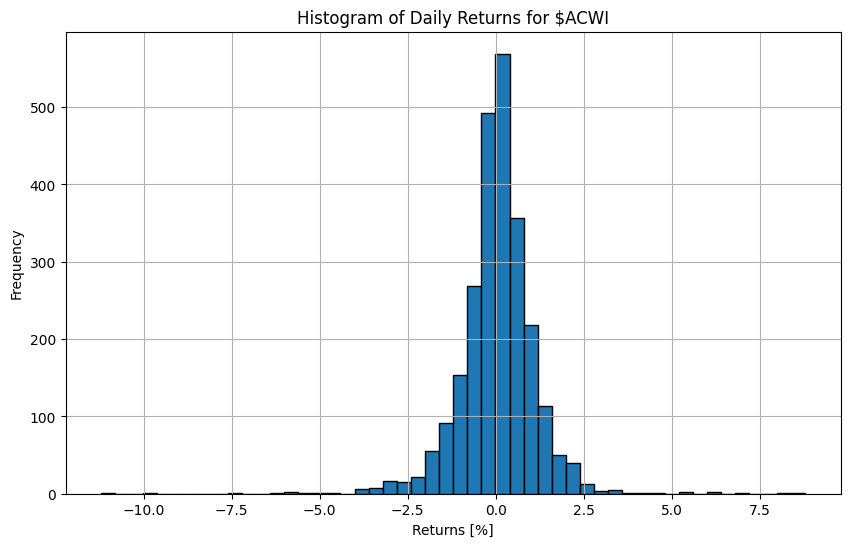

In [7]:
import matplotlib.pyplot as plt

# Plot histogram of the returns
plt.figure(figsize=(10, 6))
plt.hist(data[('Returns %', 'ACWI')].dropna(), bins=50, edgecolor='black')
plt.title('Histogram of Daily Returns for $ACWI')
plt.xlabel('Returns [%]')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [8]:
# Calculate mean and standard deviation for returns
mean_returns = data[('Returns %', 'ACWI')].mean()
std_returns = data[('Returns %', 'ACWI')].std()

# Print the results
print(f"Mean of Returns: {mean_returns}")
print(f"Standard Deviation of Returns: {std_returns}")

# calculate skewness and kurtosis.
# Gaussian distributions have a skewness close to 0 and Kurtosis close to 3.

skewness = data[('Returns %', 'ACWI')].skew()
kurtosis = data[('Returns %', 'ACWI')].kurt()

print(f"Skewness: {skewness}")
print(f"Kurtosis: {kurtosis}")

Mean of Returns: 0.03776006382454037
Standard Deviation of Returns: 1.1072095616996684
Skewness: -0.6317187314695819
Kurtosis: 13.541155206897312


In [9]:
# test probability of finding extreme returns given assumption..
# about Gaussian distribution.

from scipy.stats import norm

# Parameters of Gassuian distribution
mean = mean_returns
std_dev = std_returns

# Find extreme negative value.
# The choice between extreme positive / negative is arbitrary.

min_value = data[('Returns %', 'ACWI')].min()
x = min_value

# Calculate the cumulative probability (CDF)
cumulative_prob = norm.cdf(x, loc=mean, scale=std_dev)

# Calculate the probability density (PDF)
pdf_value = norm.pdf(x, loc=mean, scale=std_dev)

print(f"Cumulative Probability (P(X <= {x})): {cumulative_prob}")
print(f"Probability Density (PDF at {x}): {pdf_value}")

Cumulative Probability (P(X <= -11.21525226865635)): 1.4441428642454754e-24
Probability Density (PDF at -11.21525226865635): 1.338216910269647e-23


In [10]:
# What we learnt from the previous block is that the probability of the returns observed are close to impossible given assumptions about Gassuian data.

# Fit other distrubtions

Fit Johnson SU and Tukey Lambda distributions to the data instead.
These are very frequently used in financial modelling due to their
improved ability to caputre tail-events compared to the Gaussian distribution.

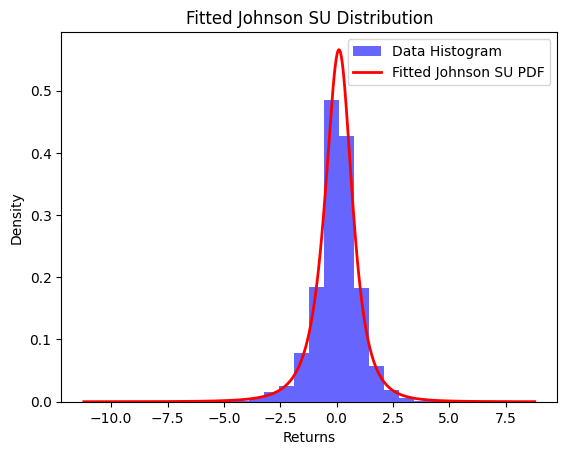

In [11]:
import numpy as np
from scipy.stats import johnsonsu

# convert to array in order be able to fit the data to johnson su distribution.

return_col = data['Returns %'].dropna()
return_arr = return_col.to_numpy()  # convert to array.

# Fit the Johnson SU distribution
johnson_params = johnsonsu.fit(return_arr)
a_su, b_su, loc_su, scale_su = johnson_params  # Shape parameters a, b, location, scale

# PDF for visualization
x = np.linspace(min(return_arr), max(return_arr), 1000)
pdf = johnsonsu.pdf(x, a_su, b_su, loc=loc_su, scale=scale_su)

# Plot
plt.hist(return_arr, bins=30, density=True, alpha=0.6, color='blue', label='Data Histogram')
plt.plot(x, pdf, 'r-', lw=2, label='Fitted Johnson SU PDF')
plt.title("Fitted Johnson SU Distribution")
plt.xlabel("Returns")
plt.ylabel("Density")
plt.legend()
plt.show()

/usr/local/lib/python3.11/dist-packages/scipy/stats/_continuous_distns.py:10513: RuntimeWarning: divide by zero encountered in power
  Px = Fx**(lam-1.0) + (np.asarray(1-Fx))**(lam-1.0)


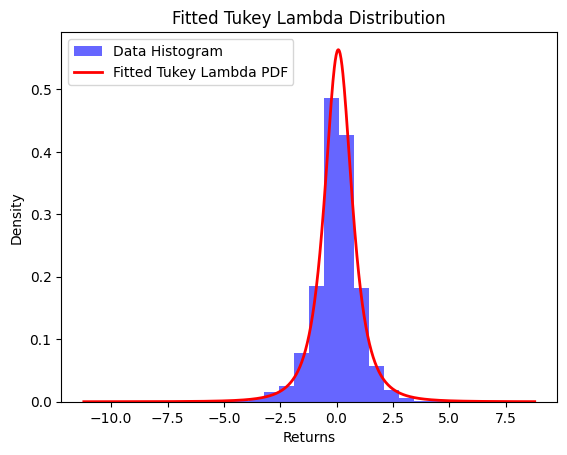

In [12]:
from scipy.stats import tukeylambda

# Fit the Tukey Lambda distribution
tukey_params = tukeylambda.fit(return_arr)
lam_tl, loc_tl, scale_tl = tukey_params  # Shape, location, scale parameters

# PDF for visualization
x = np.linspace(min(return_arr), max(return_arr), 1000)
pdf = tukeylambda.pdf(x, lam_tl, loc=loc_tl, scale=scale_tl)

# Plot
plt.hist(return_arr, bins=30, density=True, alpha=0.6, color='blue', label='Data Histogram')
plt.plot(x, pdf, 'r-', lw=2, label='Fitted Tukey Lambda PDF')
plt.title("Fitted Tukey Lambda Distribution")
plt.xlabel("Returns")
plt.ylabel("Density")
plt.legend()
plt.show()

# Kolmogorov-Smirnov test

Test how well the fitted distributions fit out-of-sample data.



In [13]:
import copy

# fetch out of sample data.

# number of years of out-of-sample data we test on.

years = 3
delta = timedelta(days = years * 365)
# end of testperiod is start of training period.
end = copy.deepcopy(start_of_period)
start = end - delta
print('start of test period: ', start, 'end of test period:', end)

# MSCI All country world index proxied by iShares ACWI ETF ticker: 'ACWI'.

ticker = 'ACWI'

# actions = True includes dividend data.
test_data = yf.download(ticker, start=start, end= end, actions = True)

# Fill NaN values with 0 before performing the calculation
test_data[('True Close', 'ACWI')] = test_data[('Close', 'ACWI')].fillna(0) + test_data[('Dividends', 'ACWI')].fillna(0)

start of test period:  2012-04-27 end of test period: 2015-04-27


[*********************100%***********************]  1 of 1 completed


In [14]:
test_data[('Returns %', 'ACWI')] = test_data[('True Close', 'ACWI')].pct_change() * 100
test_data

Price,Capital Gains,Close,Dividends,High,Low,Open,Stock Splits,Volume,True Close,Returns %
Ticker,ACWI,ACWI,ACWI,ACWI,ACWI,ACWI,ACWI,ACWI,ACWI,ACWI
Date,,,,,,,,,,
2012-04-27,0.0,35.855049,0.0,35.946925,35.694262,35.908644,0.0,650600,35.855049,NaN
2012-04-30,0.0,35.724884,0.0,35.816760,35.602381,35.816760,0.0,363900,35.724884,-0.363031
2012-05-01,0.0,35.900993,0.0,36.100062,35.633020,35.633020,0.0,516300,35.900993,0.492960
2012-05-02,0.0,35.740211,0.0,35.763180,35.495206,35.571769,0.0,524700,35.740211,-0.447848
2012-05-03,0.0,35.433964,0.0,35.740222,35.365056,35.724909,0.0,901300,35.433964,-0.856872
...,...,...,...,...,...,...,...,...,...,...
2015-04-20,0.0,50.558334,0.0,50.664774,50.370020,50.419147,0.0,759900,50.558334,0.537286
2015-04-21,0.0,50.705719,0.0,50.943160,50.672968,50.894033,0.0,2212200,50.705719,0.291514


In [15]:
col = test_data['Returns %'].dropna()
test_arr = col.to_numpy()

In [16]:
from scipy.stats import kstest

# Perform KS tests
ks_johnsonsu = kstest(test_arr, 'johnsonsu', args=johnson_params)
ks_tukeylambda = kstest(test_arr, 'tukeylambda', args=tukey_params)
ks_gaussian = kstest(test_arr, 'norm', args=(mean, std_dev))


# Interpretation:
# KS statistic: lower value --> better.
# Less distance between observed results and pdf.
#
# P-value, higher value --> better.
# More confidence the distribution is a good fit.

# Display results

# Display results
print("=== Gaussian ===")
print(f"Parameters: mean={mean}, standard deviation={std_dev}")
print(f"KS Statistic: {ks_gaussian.statistic}")
print(f"P-Value: {ks_gaussian.pvalue}")

print("\n=== Johnson SU ===")
print(f"Parameters: a={a_su}, b={b_su}, loc={loc_su}, scale={scale_su}")
print(f"KS Statistic: {ks_johnsonsu.statistic}")
print(f"P-Value: {ks_johnsonsu.pvalue}")

print("\n=== Tukey Lambda ===")
print(f"Parameters: loc={loc_tl}, scale={scale_tl}")
print(f"KS Statistic: {ks_tukeylambda.statistic}")
print(f"P-Value: {ks_tukeylambda.pvalue}")

=== Gaussian ===
Parameters: mean=0.03776006382454037, standard deviation=1.1072095616996684
KS Statistic: [0.1130601]
P-Value: [8.10199385e-09]

=== Johnson SU ===
Parameters: a=0.10462651453254046, b=1.1399960228303831, loc=0.1487781785578856, scale=0.8020324863379076
KS Statistic: [0.03866444]
P-Value: [0.20613832]

=== Tukey Lambda ===
Parameters: loc=0.07690031361278163, scale=0.3799193281783578
KS Statistic: [0.04581583]
P-Value: [0.0828392]


# Fitt Gaussian Mixture Model (GMM)

In [17]:
# prepare data for GMM giy

In [18]:
data[('Returns %', 'ACWI')] = data[('True Close', 'ACWI')].pct_change() * 100

return_col = data[('Returns %', 'ACWI')].dropna()

returns_arr = return_col.to_numpy()

print(returns_arr.shape)

# the data needs to in the form of [n_samples, n_features]

returns_arr = returns_arr.reshape(-1, 1) # one dim can be -1, it's dimensons are inferred.
print(returns_arr.shape)

(2513,)
(2513, 1)


GMM Parameters:
Weights: [0.6094116  0.14581229 0.24477611]
Means: [ 0.04387971 -0.44810545  0.31195259]
Covariances: [0.34710985 4.89842266 1.00825409]


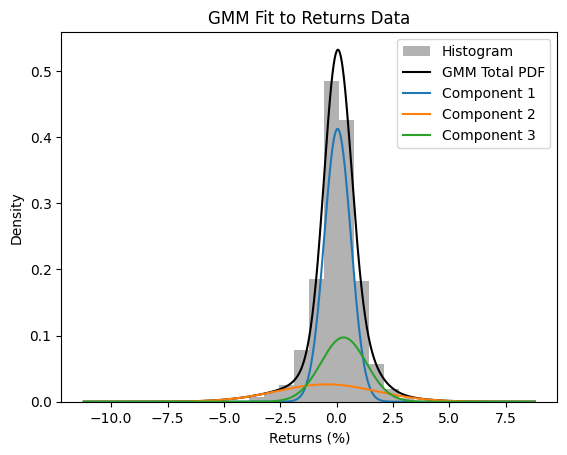

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture


# Initialize and fit the GMM
gmm = GaussianMixture(
    n_components=3,  # Number of Gaussian components (adjust as needed)
    covariance_type='full',  # Each component has its own general covariance matrix
    random_state=42  # Ensures reproducibility
)


gmm.fit(returns_arr)

# Extract GMM parameters
weights = gmm.weights_
means = gmm.means_.flatten()
covariances = gmm.covariances_.flatten()

print("GMM Parameters:")
print(f"Weights: {weights}")
print(f"Means: {means}")
print(f"Covariances: {covariances}")

# Plot the original data histogram and GMM components

#############################################################################
# pdf explanation
# score_samples computes the log-likelihood of the domain
# The likelihood function on the domain is the pdf by definition.
# log is used for computational stability.
# it's exponented with np.exp(.) to undo the log-operation and give the pdf.
############################################################################

x = np.linspace(returns_arr.min(), returns_arr.max(), 1000).reshape(-1, 1)
pdf = np.exp(gmm.score_samples(x))  # GMM PDF
components = [weights[i] * np.exp(-0.5 * ((x - means[i])**2) / covariances[i]) /
              np.sqrt(2 * np.pi * covariances[i]) for i in range(len(weights))]

plt.hist(returns_arr, bins=30, density=True, alpha=0.6, color='gray', label='Histogram')
plt.plot(x, pdf, label='GMM Total PDF', color='black')
for i, comp in enumerate(components):
    plt.plot(x, comp, label=f'Component {i+1}')
plt.legend()
plt.title('GMM Fit to Returns Data')
plt.xlabel('Returns (%)')
plt.ylabel('Density')
plt.show()

In [20]:
from scipy.stats import norm, ks_1samp

weights = gmm.weights_
means = gmm.means_.flatten()
covariances = gmm.covariances_.flatten()

cdf = 0
for weight, mean, covar in zip(gmm.weights_, gmm.means_.flatten(), gmm.covariances_.flatten()):
  cdf += weight * norm.cdf(x, loc=mean, scale=np.sqrt(covar))

In [21]:
######################### K-S test of the GMM
# now I don't have a distribution implemented by scipy.
# But, I can use scipy.stats ks_1samp to do the test anyway.
# 'This test compares the underlying distribution F(x) of a sample against a given continuous distribution G(x)'
# from the documentation:
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ks_1samp.html
###


from scipy.stats import norm, ks_1samp

# Define the CDF of the GMM
# Theory:
# CDF of a GMM is Sigma_k w_k * cdf_k,
# where w_k is the weight of the kth component,
# cdf_k is the cdf of the kth component
# and Sigma_k is summation with respect to k.

def gmm_cdf(x, gmm):
    """
    Compute the CDF of a Gaussian Mixture Model at x.
    """
    cdf = 0
    for weight, mean, covar in zip(gmm.weights_, gmm.means_.flatten(), gmm.covariances_.flatten()):
        cdf += weight * norm.cdf(x, loc=mean, scale=np.sqrt(covar))
    return cdf

# Apply the K-S test
def ks_test_gmm(data, gmm):
    """
    Perform the Kolmogorov-Smirnov test for a GMM.
    """
    cdf_values = np.array([gmm_cdf(x, gmm) for x in data])
    ks_statistic, p_value = ks_1samp(data, lambda x: gmm_cdf(x, gmm))
    return ks_statistic, p_value

# Perform the test
ks_stat, p_val = ks_test_gmm(test_arr, gmm)
print(f"K-S Statistic: {ks_stat}, P-value: {p_val}")

K-S Statistic: [0.04747831], P-value: [0.06554322]


In [22]:
# Fit different gmm models using different amount of modes.
# Use the best one

p_best = 0

# n represents number of modes to try
for n in range(2, 20):

  gmm_current = GaussianMixture(
      n_components=n,  # Number of Gaussian components (adjust as needed)
      covariance_type='full',  # Each component has its own general covariance matrix
      random_state=42  # Ensures reproducibility
  )


  gmm_current.fit(returns_arr)


  ks_stat, p_val = ks_test_gmm(test_arr, gmm_current)
  #print(f"K-S Statistic: {ks_stat}, P-value: {p_val}, Number of modes: {n}")
  if p_val > p_best:
    p_best = p_val
    gmm_best = gmm_current
    n_best = n
    print(f'New best: K-S Statistic: {ks_stat}, P-value: {p_val}, Number of modes: {n_best}')

New best: K-S Statistic: [0.05267197], P-value: [0.02988537], Number of modes: 2
New best: K-S Statistic: [0.04747831], P-value: [0.06554322], Number of modes: 3
New best: K-S Statistic: [0.04723888], P-value: [0.06782644], Number of modes: 6
New best: K-S Statistic: [0.04523518], P-value: [0.08972316], Number of modes: 9


K-S Statistic: [0.04523518], P-value: [0.08972316]
GMM Parameters:
Number of modes: 9
Weights: [0.21040193 0.16711696 0.02451688 0.13335284 0.00495333 0.00525496
 0.03814657 0.09493424 0.32132227]
Means: [ 0.49199583 -0.56411794 -2.71208669  1.12247918 -5.60134153  5.15928944
  2.05214252 -1.34792    -0.01357535]
Covariances: [0.0601148  0.07175135 0.37332336 0.09497769 7.75107676 4.09495799
 0.27044017 0.14013908 0.04954623]


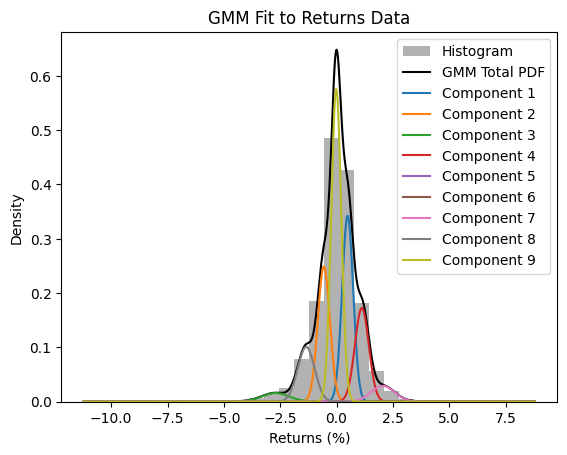

In [23]:
# plot the best GMM-fit.

weights = gmm_best.weights_
means = gmm_best.means_.flatten()
covariances = gmm_best.covariances_.flatten()

ks_stat, p_val = ks_test_gmm(test_arr, gmm_best)
print(f"K-S Statistic: {ks_stat}, P-value: {p_val}")
print("GMM Parameters:")
print(f"Number of modes: {n_best}")
print(f"Weights: {weights}")
print(f"Means: {means}")
print(f"Covariances: {covariances}")


x = np.linspace(returns_arr.min(), returns_arr.max(), 1000).reshape(-1, 1)
pdf = np.exp(gmm_best.score_samples(x))  # GMM PDF
components = [weights[i] * np.exp(-0.5 * ((x - means[i])**2) / covariances[i]) /
              np.sqrt(2 * np.pi * covariances[i]) for i in range(len(weights))]

plt.hist(returns_arr, bins=30, density=True, alpha=0.6, color='gray', label='Histogram')
plt.plot(x, pdf, label='GMM Total PDF', color='black')
for i, comp in enumerate(components):
    plt.plot(x, comp, label=f'Component {i+1}')
plt.legend()
plt.title('GMM Fit to Returns Data')
plt.xlabel('Returns (%)')
plt.ylabel('Density')
plt.show()